<a href="https://colab.research.google.com/github/shubymao/comp551-p3/blob/shuby-dev/Project_3_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project 3 - Convolution Neural Network

## Team Members

Le-Li Mao (260800098)

Victor Livernoche (260926276)

Enan Ashaduzzaman (260805923)

## Initializing Dependency

In [1]:
from __future__ import print_function
import pickle as pkl
import numpy as np
import argparse
from tqdm import tqdm
from sklearn.preprocessing import normalize

import cv2

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, random_split
import torchvision
from torchvision import datasets, transforms
import pandas as pd

%matplotlib inline
from mpl_toolkits.axes_grid1 import ImageGrid
import matplotlib.pyplot as plt
import string
from google.colab import drive
drive.mount('/content/drive')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Loading Data

In [22]:
mapping = list(string.ascii_lowercase) 
training_data, training_labels, testing_data = None, None, None
with open("/content/drive/My Drive/data/images_l.pkl", 'rb') as f: 
    training_data = pkl.load(f)
with open("/content/drive/My Drive/data/labels_l.pkl", 'rb') as f: 
    training_labels = pkl.load(f)
with open("/content/drive/My Drive/data/images_test.pkl", 'rb') as f: 
    testing_data = pkl.load(f)

## Preprocessing

Create the pipeline for handling data

In [23]:
def nomalize_img(img):
  cliped_img = np.clip(img, 0, 255)
  subtracted_img = cliped_img - cliped_img.mean() + 10
  normalized_img = subtracted_img / np.max(subtracted_img) * 255
  return normalized_img

In [24]:
def extract_key_item(original, padding=2, threshold=100 , show_all = False, debug=False):
  stages = None
  img = cv2.normalize(original, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)
  img_blur = cv2.GaussianBlur(img, (7, 7), 0)
  (_, thresh) = cv2.threshold(img_blur, 65, 255, cv2.THRESH_BINARY)
  if debug: plt.imshow(img_blur); plt.show()
  if debug: plt.imshow(thresh); plt.show()
  contours, _ = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
  key_items = []
  bounding_box_cords = []
  for c in contours:
      x,y,w,h = cv2.boundingRect(c)
      if show_all or debug: cv2.rectangle(img, (x, y), (x + w, y + h), 255, 1)
      if(w < 10 and h < 10): # select elements with at least 10px width or 10 px height
        continue
      dup = False
      for (px, py) in bounding_box_cords:
        if abs(px-x)+abs(py-y) < 10:
          dup = True
      if dup: continue   
      key_items.append(original[y-padding:y+h+padding,x-padding:x+w+padding].copy())
      
      bounding_box_cords.append((x,y,))
  if show_all: 
    stages = [img_blur, thresh, img]
  if debug: plt.imshow(img); plt.show()
  return stages, key_items

In [25]:
def pad_to_fixed_size(img, width, height):
  row, col = img.shape
  if row > height or col > width: 
    return None
  pl = (width - col)// 2
  pt = (height - row)// 2
  pr = (width - col - pl)
  pb = (height - row - pt)
  return np.pad(img, [(pt,pb),(pl,pr)], 'constant')

In [26]:
def merge_key_items(key_items):
  if len(key_items) >= 2:
    item1 = pad_to_fixed_size(key_items[0],28,56)
    item2 = pad_to_fixed_size(key_items[1],28,56)
    if item1 is None or item2 is None: return None
    result = np.concatenate((item1,item2), axis = 1)
    return result 
  return None

In [27]:
def pre_processing(original, show_all=False, debug=False):
  normalized_img = nomalize_img(original.copy())
  if debug: plt.imshow(normalized_img); plt.show()
  extract_stages, key_items = extract_key_item(normalized_img, show_all=show_all, debug=debug)
  if debug: [(plt.imshow(item), plt.show()) for item in key_items]
  result = merge_key_items(key_items)
  #result = cv2.normalize(result, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)
  #result = cv2.fastNlMeansDenoising(result, None, 3, 7)
  #result = cv2.threshold(result, 65, 255, cv2.THRESH_BINARY)
  #result = np.asarray(result)
  if result is None: return normalized_img, None, False
  stages = None
  if show_all:
    stages = [original, normalized_img, *extract_stages, *key_items, result]
  return result, stages, True

In [28]:
def convert_labels_to_readables(labels):
  readables = []
  for label in labels:
    l1 = np.argmax(label[0:10])
    l2 = mapping[np.argmax(label[10:])]
    readables.append((l1,l2,))
  return readables

In [29]:
# show images
def img_grid(row,col,imgs):
  if imgs is None: return
  for r in range(row):
    fig, axs = plt.subplots(nrows=1, ncols=col, figsize=(7.,10.))
    for i, ax in enumerate(axs.flatten()):
        if(len(imgs) <= r*col+i): 
          return
        plt.sca(ax)
        plt.imshow(imgs[r*col+i])
        #plt.colorbar()
    plt.show()

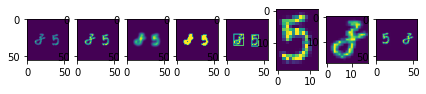

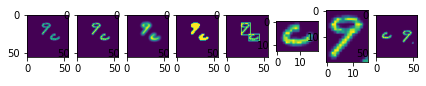

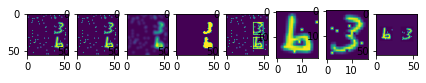

In [30]:
# Test the preprocessing functions
for ind in np.random.choice(training_data.shape[0], 3, replace=False):
  img = training_data[ind]
  _, stages,_ = pre_processing(img, show_all=True)
  if stages is not None: img_grid(1,len(stages),stages)

In [31]:
# transform all data to the output format
def process_data(data):
  output, bad_index = [], []
  for i in range(len(data)):
      result,_,valid = pre_processing(data[i])
      output.append(result)
      if not valid:
        bad_index.append(i)
  output = np.array(output).astype('float64')
  return output, bad_index

def normalize_data(data):
  output = []
  for i in range(len(data)):
      output.append(nomalize_img(data[i].copy()))
  output = np.array(output).astype('float64')
  return output

In [32]:
normalized_training_data = normalize_data(training_data)
processed_training_data, bad_training_index = process_data(training_data)

print(f'Number of training data element unable to be separated: {len(bad_training_index)}')
processed_training_data = np.delete(processed_training_data, bad_training_index, axis=0)
processed_training_labels = np.delete(training_labels, bad_training_index, axis=0)
# We append the processed to original as additional training data
final_training_data = np.append(normalized_training_data, processed_training_data, axis=0)
final_training_labels = np.append(training_labels, processed_training_labels, axis=0)

print(final_training_data.shape)
print(final_training_labels.shape)
# Clean up to reduce memory footprint
training_data, processed_training_data, normalized_training_data = None, None, None
training_labels, processed_training_labels = None, None

Number of training data element unable to be separated: 4277
(55723, 56, 56)
(55723, 36)


In [33]:
processed_testing_data, bad_testing_index = process_data(testing_data)
print(f'Number of test data element unable to be processed: {len(bad_testing_index)}')
print(np.shape(processed_testing_data))
testing_data = None

Number of test data element unable to be processed: 2066
(15000, 56, 56)


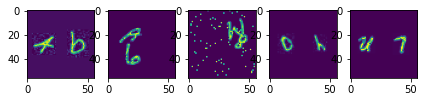

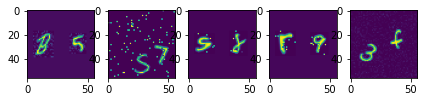

[(4, 'b'), (6, 'a'), (8, 'w'), (0, 'h'), (7, 'u'), (5, 'b'), (7, 's'), (8, 's'), (9, 'r'), (3, 'f')]


In [34]:
def show_random_sample(n):
  index = np.random.choice(final_training_data.shape[0], n, replace=False)  
  img_grid(n//5,5,final_training_data[index])
  print(convert_labels_to_readables(final_training_labels[index]))
show_random_sample(10)

Put the data into dataloader

In [35]:
training_tensor = torch.from_numpy(final_training_data[:,None]).float()
number_label_tensor = torch.from_numpy(np.argmax(final_training_labels[:,0:10],1))
letter_label_tensor = torch.from_numpy(np.argmax(final_training_labels[:,10:36],1))
multi_label_tensor = torch.stack((number_label_tensor,letter_label_tensor), axis=1)

# mixed_label_tensor = torch.cat((number_label_tensor, letter_label_tensor), 0)
# mixed_training_tensor = torch.cat((training_tensor, training_tensor), 0)
# mixed_training_dataset = TensorDataset(mixed_training_tensor, mixed_label_tensor)
# mixed_training_dataloader = DataLoader(mixed_training_dataset, batch_size=30, shuffle=True, num_workers=2)

multi_training_dataset = TensorDataset(training_tensor, multi_label_tensor)
#multi_training_dataloader = DataLoader(multi_training_dataset, batch_size=30, shuffle=True, num_workers=2)

train_size = int(0.9*len(multi_training_dataset))
validation_size = len(multi_training_dataset)-train_size

multi_training_dataset, multi_validation_dataset = random_split(multi_training_dataset, [train_size, validation_size])
multi_training_dataloader = DataLoader(multi_training_dataset, batch_size=30, shuffle=True, num_workers=2)
multi_validation_dataloader = DataLoader(multi_validation_dataset, batch_size=30, shuffle=True, num_workers=2)

training_tensor, number_label_tensor, multi_label_tensor = None, None, None
multi_training_dataset, multi_validation_dataset = None, None
final_training_data, final_training_labels = None, None

## Training Model

Initialize network validation and training function

In [70]:
def validate_model(model, validation_dataloader):
  digit_acc, letter_acc = 0, 0
  print("Starting Validation Iteration")
  for i, validation_data in enumerate(tqdm(validation_dataloader)):
    inputs, labels = validation_data
    o1, o2 = model(inputs)
    l1, l2 = labels[:,0], labels[:,1]
    digit_acc += torch.mean((torch.argmax(o1, dim=1) == l1).float()).float()
    letter_acc += torch.mean((torch.argmax(o2, dim=1) == l2).float())
  digit_acc = digit_acc/len(validation_dataloader)
  letter_acc = letter_acc / len(validation_dataloader)
  print(f'Digit Accuracy: {digit_acc.item()}, Letter Accuracy: {letter_acc.item()}')
  return (digit_acc.item(), letter_acc.item())

In [95]:
def train_network(net, dataloader, validation_dataloader, lr = 0.005, momentum = 0.9, max_epoch = 10, criterion = nn.CrossEntropyLoss()):
  optimizer = optim.SGD(net.parameters(), lr=lr, momentum=momentum)
  running_loss = 0.0
  digits_accs, letter_accs = [], []
  for epoch in range(max_epoch):  # loop over the dataset multiple times
      cnt = 0
      print("Starting Training Iteration")
      for i, data in enumerate(tqdm(dataloader)):
          inputs, labels = data
          optimizer.zero_grad()
          outputs = net(inputs)
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()
          running_loss += loss.item()
          cnt+=1
          if i % 100 == 99:
            # print triaing statistics
            print('[%d] loss: %.3f \n' % (epoch + 1, running_loss / cnt))
            running_loss, cnt = 0.0, 0
      digit_acc, letter_acc = validate_model(net, validation_dataloader)
      digits_accs.append(digit_acc)
      letter_accs.append(letter_acc)
  return (digits_accs, letter_accs)

### Multi-Output Model

Initalize the Multilabel Model

In [97]:
class MultiNet(nn.Module):
    def __init__(self):
        super(MultiNet, self).__init__()
         # 8 convolution layer

        self.conv11 = nn.Conv2d(1, 20, 3, padding='same')
        self.conv12 = nn.Conv2d(20, 20, 3, padding='same')

        self.conv31 = nn.Conv2d(20, 40, 3, padding='same')
        self.conv32 = nn.Conv2d(40, 40, 3, padding='same')
        self.conv33 = nn.Conv2d(40, 40, 3, padding='same')

        self.conv41 = nn.Conv2d(40, 80, 3, padding='same')
        self.conv42 = nn.Conv2d(80, 80, 3, padding='same')
        self.conv43 = nn.Conv2d(80, 80, 3, padding='same')

        # 3 Dense Layer
        self.fc1 = nn.Linear(80*6*6, 500)  
        self.fc2 = nn.Linear(500, 500)
        self.fc31 = nn.Linear(500, 10)
        self.fc32 = nn.Linear(500, 26)

    def forward(self, x):
        # Convolution Layers
        x = F.relu(self.conv12(F.relu(self.conv11(x))))
        x = F.max_pool2d(x, 3, stride=2)
        x = F.relu(self.conv33(F.relu(self.conv32(F.relu(self.conv31(x))))))
        x = F.max_pool2d(x, 3, stride=2)
        x = F.relu(self.conv43(F.relu(self.conv42(F.relu(self.conv41(x))))))
        x = F.max_pool2d(x, 3, stride=2)
        # print(x.size())
        # Dense Layers
        x = x.view(-1,self.num_flat_features(x)) # Flatten
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        l1 = F.relu(self.fc31(x))
        l2 = F.relu(self.fc32(x))
        return l1,l2
    
    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

In [ ]:
def train_model():
  multi_net = MultiNet()
  multi_net_criterion = nn.CrossEntropyLoss()
  lr, epoch = 0.001, 5 
  def ml_criterion(output, labels):
    o1, o2 = output
    l1, l2 = labels[:,0], labels[:,1]
    loss1 = multi_net_criterion(o1,l1)
    loss2 = multi_net_criterion(o2,l2)
    return loss1 + loss2
  res = train_network(multi_net, multi_training_dataloader, multi_validation_dataloader, criterion=ml_criterion, lr=lr, max_epoch=epoch)
  digit_accuracies, letter_accuracies = res
  plt.plot(range(1, epoch+1), digit_accuracies, 'bo-')
  plt.plot(range(1, epoch+1), letter_accuracies, 'ro-')
  return multi_net
multi_net = train_model()

Starting Training Iteration


  6%|▌         | 100/1672 [00:37<09:41,  2.70it/s]

[1] loss: 5.561 



 12%|█▏        | 200/1672 [01:14<09:07,  2.69it/s]

[1] loss: 5.560 



 18%|█▊        | 300/1672 [01:51<08:25,  2.72it/s]

[1] loss: 5.559 



 24%|██▍       | 400/1672 [02:28<07:52,  2.69it/s]

[1] loss: 5.558 



 30%|██▉       | 500/1672 [03:05<07:23,  2.64it/s]

[1] loss: 5.556 



 36%|███▌      | 600/1672 [03:42<06:36,  2.70it/s]

[1] loss: 5.555 



 42%|████▏     | 700/1672 [04:19<05:55,  2.73it/s]

[1] loss: 5.554 



 48%|████▊     | 800/1672 [04:56<05:18,  2.74it/s]

[1] loss: 5.543 



 54%|█████▍    | 900/1672 [05:33<04:48,  2.68it/s]

[1] loss: 5.536 



 60%|█████▉    | 1000/1672 [06:11<04:12,  2.66it/s]

[1] loss: 5.489 



 66%|██████▌   | 1100/1672 [06:48<03:31,  2.71it/s]

[1] loss: 5.408 



 72%|███████▏  | 1200/1672 [07:25<02:56,  2.67it/s]

[1] loss: 5.369 



 78%|███████▊  | 1300/1672 [08:02<02:17,  2.70it/s]

[1] loss: 5.277 



 84%|████████▎ | 1400/1672 [08:40<01:40,  2.70it/s]

[1] loss: 5.187 



 90%|████████▉ | 1500/1672 [09:17<01:03,  2.69it/s]

[1] loss: 5.020 



 96%|█████████▌| 1600/1672 [09:54<00:26,  2.72it/s]

[1] loss: 4.812 



100%|██████████| 1672/1672 [10:20<00:00,  2.69it/s]


Starting Validation Iteration


 72%|███████▏  | 133/186 [00:19<00:07,  6.97it/s]

## Testing Model

Test the multi output network

In [ ]:
img_grid(2,5,final_training_data[200:210])
l1,l2 = multi_net(torch.from_numpy(final_training_data[200:210,None]).float())
letter_prediction = list(map(lambda x: mapping[x], np.argmax(l2.detach().numpy(),axis=1)))
prediction = list(zip(np.argmax(l1.detach().numpy(),axis=1),letter_prediction))
print(prediction)

In [ ]:
validation_data, validation_labels = multi_validation_dataset[:]

l1,l2 = multi_net(validation_data)

accuracy_digits = np.mean(np.argmax(l1.detach().numpy(), axis=1)==validation_labels.detach().numpy()[:, 0])
accuracy_letters = np.mean(np.argmax(l2.detach().numpy(), axis=1)==validation_labels.detach().numpy()[:, 1])
#accuracy = np.mean(np.all(np.argmax(l1.detach().numpy(), axis=1)==validation_labels.detach().numpy()[:, 0], np.argmax(l2.detach().numpy(), axis=1)==validation_labels.detach().numpy()[:, 1]))
print(accuracy_digits)
print(accuracy_letters)
#print(accuracy)
#and np.argmax(l2.detach().numpy(), axis=1)==np.argmax(final_training_labels[None, 11:27], axis=1)))

0.7929301991745917
0.5609187152341647


## Results

In [ ]:
def LabelToString(label, isDigit):
  s = ""
  r = 0
  if (isDigit):
    r = 10
  else:
    r = 26
  for i in range(0, r):
    if (i == label):
      s += '1'
    else:
      s += '0'
  return s


l1,l2 = multi_net(torch.from_numpy(processed_testing_data[:, None]).float())
category = []
id = []
l1 = np.argmax(l1.detach().numpy(), axis=1)
l2 = np.argmax(l2.detach().numpy(), axis=1)
for i in range(0, len(l1)):
  a = LabelToString(l1[i], True)
  b = LabelToString(l2[i], False)
  category.append(a+b)
  id.append(i)

In [ ]:
# need to create data dict
data = {
    'Id' : id,
    'Category' : category
}

df = pd.DataFrame(data=data, columns= ['Id', 'Category'])
print(df)
df.to_csv('/content/drive/My Drive/data/results.csv', index = False, header=True)

          Id                              Category
0          0  100000000000000000000000000001000000
1          1  000010000000000001000000000000000000
2          2  000000000100000000000000000010000000
3          3  100000000000000000000100000000000000
4          4  000000100000000000010000000000000000
...      ...                                   ...
14995  14995  000100000000001000000000000000000000
14996  14996  000100000010000000000000000000000000
14997  14997  000000100010000000000000000000000000
14998  14998  010000000000000000100000000000000000
14999  14999  001000000000000000001000000000000000

[15000 rows x 2 columns]
